In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV ,RepeatedStratifiedKFold, cross_val_score , StratifiedKFold ,GroupKFold,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids , NearMiss

/kaggle/input/customersegmentation/CustomerSegmentation/sample_submission.csv
/kaggle/input/customersegmentation/CustomerSegmentation/Test.csv
/kaggle/input/customersegmentation/CustomerSegmentation/Train.csv


In [2]:
train_data = pd.read_csv('../input/customersegmentation/CustomerSegmentation/Train.csv')
test_data = pd.read_csv('../input/customersegmentation/CustomerSegmentation/Test.csv')

In [3]:
print(train_data.shape)
train_data.head()

(8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
print(test_data.shape)
test_data.head()

(2627, 10)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [5]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except:
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 140 for column Ever_Married
Total Na values is 78 for column Graduated
Total Na values is 124 for column Profession
Total Na values is 829 for column Work_Experience
Total Na values is 335 for column Family_Size
Total Na values is 76 for column Var_1


['Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size', 'Var_1']
Work_Experience    10.275161
Family_Size         4.152206
Ever_Married        1.735250
Profession          1.536936
Graduated           0.966782
Var_1               0.941993
dtype: float64


test_data
Total Na values is 50 for column Ever_Married
Total Na values is 24 for column Graduated
Total Na values is 38 for column Profession
Total Na values is 269 for column Work_Experience
Total Na values is 113 for column Family_Size
Total Na values is 32 for column Var_1


['Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size', 'Var_1']
Work_Experience    10.239817
Family_Size         4.301485
Ever_Married  

Text(0.5, 1.0, 'Segments')

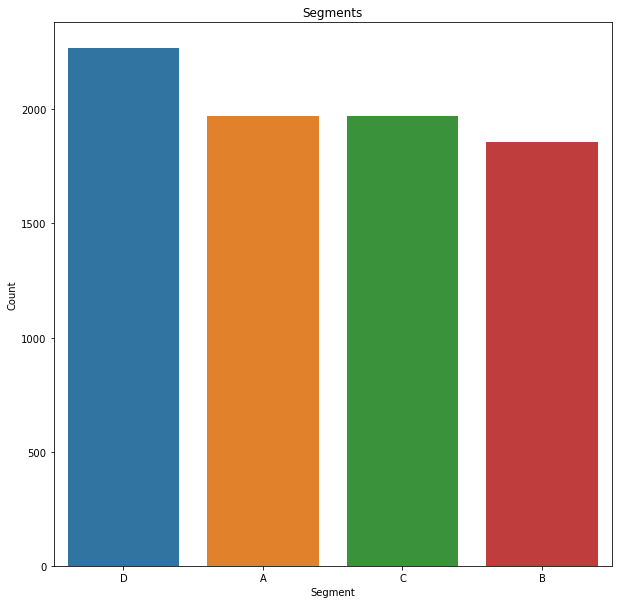

In [7]:
segments = train_data.loc[:,"Segmentation"].value_counts()
plt.xlabel("Segment")
plt.ylabel('Count')
sns.barplot(segments.index , segments.values).set_title('Segments')

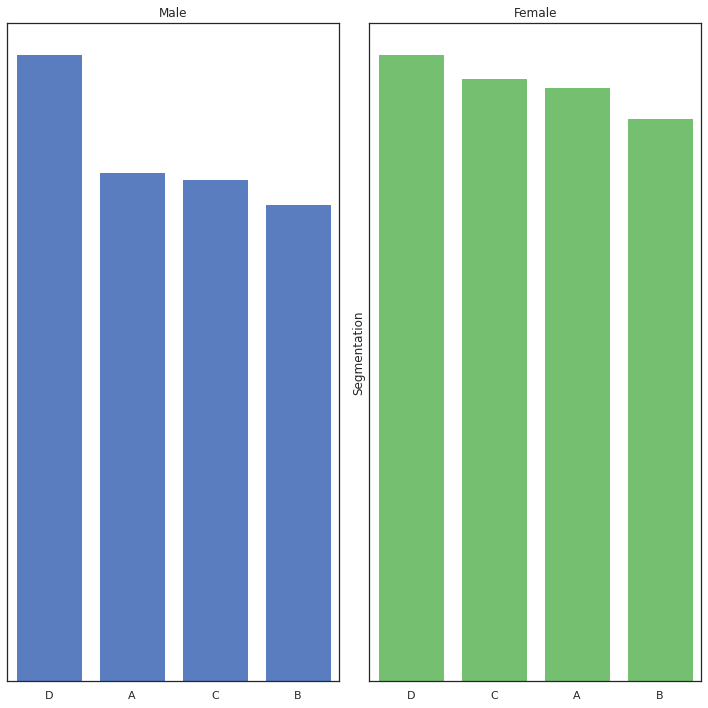

In [8]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(10, 10))
#sns.despine(left=True)

segments_male = train_data.loc[train_data.Gender == 'Male',"Segmentation"].value_counts()
sns.barplot(segments_male.index , segments_male.values,  color="b", ax=axes[0]).set_title('Male')

segments_female = train_data.loc[train_data.Gender == 'Female',"Segmentation"].value_counts()
sns.barplot(segments_female.index , segments_female,   color="g", ax=axes[1]).set_title('Female')

plt.setp(axes, yticks=[])
plt.tight_layout()

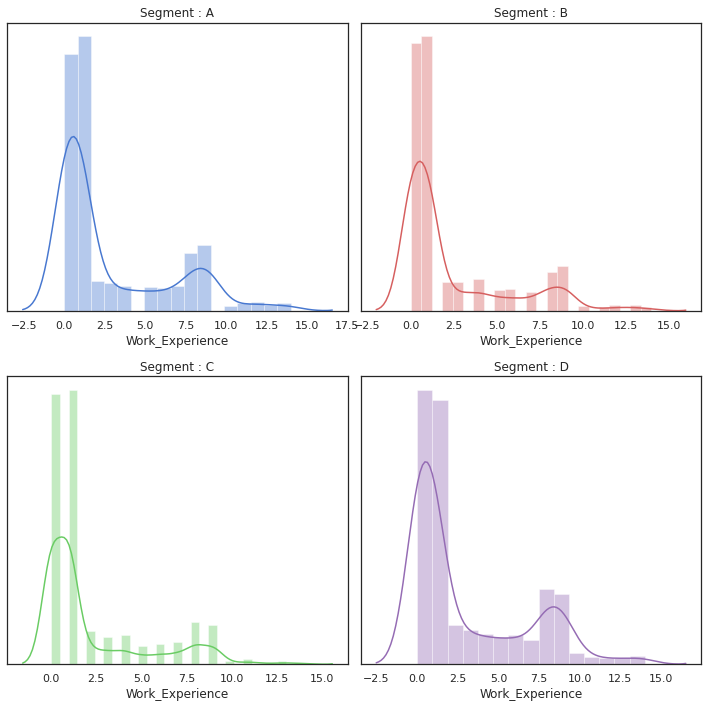

In [9]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(10, 10))
#sns.despine(left=True)

sns.distplot(train_data[train_data.Segmentation =='A']["Work_Experience"],  color="b", ax=axes[0, 0]).set_title('Segment : A')

sns.distplot(train_data[train_data.Segmentation =='B']["Work_Experience"],   color="r", ax=axes[0, 1]).set_title('Segment : B')

sns.distplot(train_data[train_data.Segmentation =='C']["Work_Experience"],  color="g", ax=axes[1, 0]).set_title('Segment : C')

sns.distplot(train_data[train_data.Segmentation =='D']["Work_Experience"], color="m", ax=axes[1, 1]).set_title('Segment : D')

plt.setp(axes, yticks=[])
plt.tight_layout()

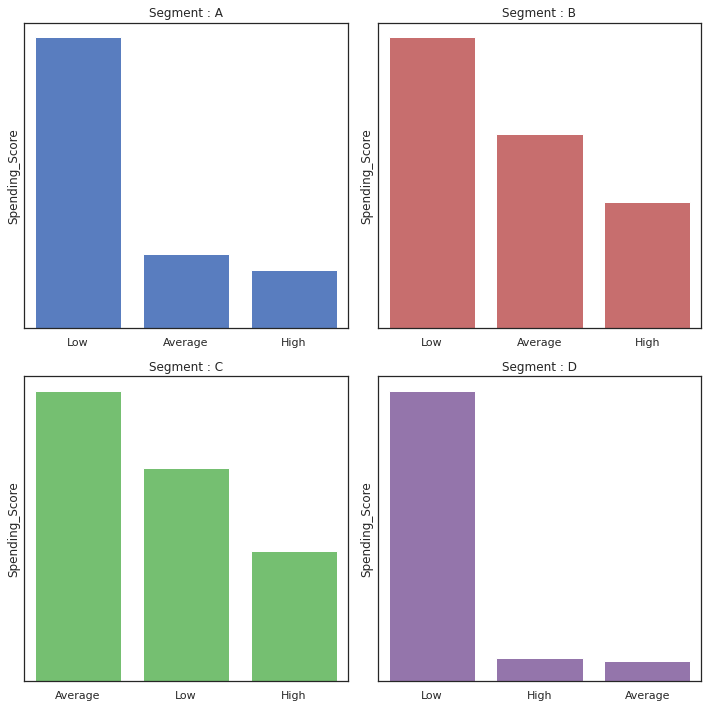

In [10]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(10, 10))
#sns.despine(left=True)

sns.barplot(train_data[train_data.Segmentation =='A']["Spending_Score"].value_counts().index,train_data[train_data.Segmentation =='A']["Spending_Score"].value_counts(),  color="b", ax=axes[0, 0]).set_title('Segment : A')

sns.barplot(train_data[train_data.Segmentation =='B']["Spending_Score"].value_counts().index,train_data[train_data.Segmentation =='B']["Spending_Score"].value_counts(),   color="r", ax=axes[0, 1]).set_title('Segment : B')

sns.barplot(train_data[train_data.Segmentation =='C']["Spending_Score"].value_counts().index,train_data[train_data.Segmentation =='C']["Spending_Score"].value_counts(),  color="g", ax=axes[1, 0]).set_title('Segment : C')

sns.barplot(train_data[train_data.Segmentation =='D']["Spending_Score"].value_counts().index,train_data[train_data.Segmentation =='D']["Spending_Score"].value_counts(), color="m", ax=axes[1, 1]).set_title('Segment : D')

plt.setp(axes, yticks=[])
plt.tight_layout()

In [11]:
train_data.groupby('Age')['Segmentation'].describe()

,count,unique,top,freq
Age,,,,
18,132,4,D,122
19,134,4,D,120
20,127,4,D,111
21,116,4,D,102
22,142,4,D,127
...,...,...,...,...
85,22,4,D,9
86,30,4,A,10
87,28,4,A,14


In [12]:
train_data.groupby(['Segmentation'])["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Segmentation,,,,,,,,
A,1972.0,44.924949,16.406909,18.0,33.0,41.0,52.0,89.0
B,1858.0,48.200215,14.806443,18.0,37.0,46.0,58.0,89.0
C,1970.0,49.144162,14.575090,18.0,38.0,49.0,59.0,89.0
D,2268.0,33.390212,15.680304,18.0,22.0,29.0,38.0,89.0


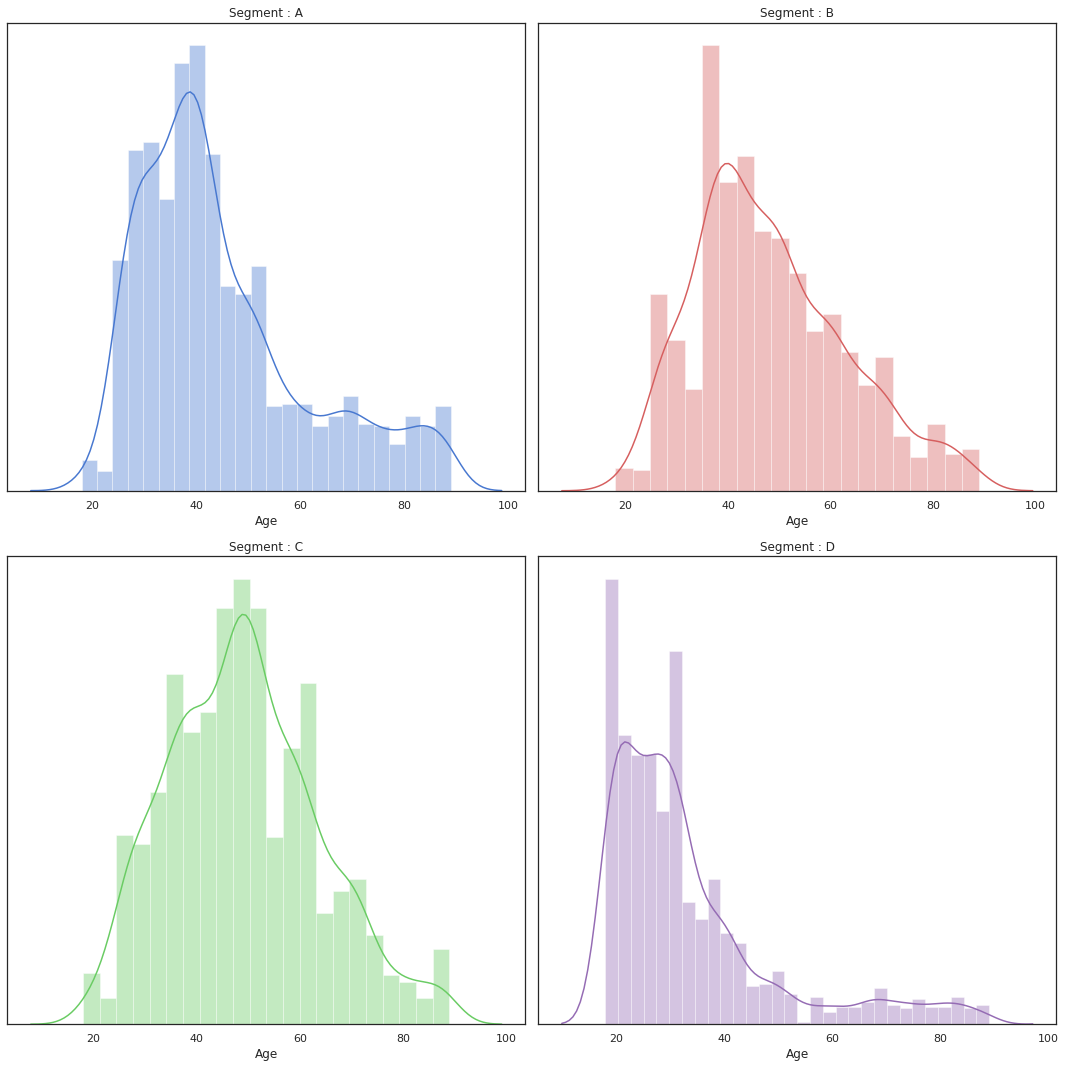

In [13]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(15, 15))
#sns.despine(left=True)

sns.distplot(train_data[train_data.Segmentation =='A']["Age"],  color="b", ax=axes[0, 0]).set_title('Segment : A')

sns.distplot(train_data[train_data.Segmentation =='B']["Age"],   color="r", ax=axes[0, 1]).set_title('Segment : B')

sns.distplot(train_data[train_data.Segmentation =='C']["Age"],  color="g", ax=axes[1, 0]).set_title('Segment : C')

sns.distplot(train_data[train_data.Segmentation =='D']["Age"], color="m", ax=axes[1, 1]).set_title('Segment : D')

plt.setp(axes, yticks=[])
plt.tight_layout()

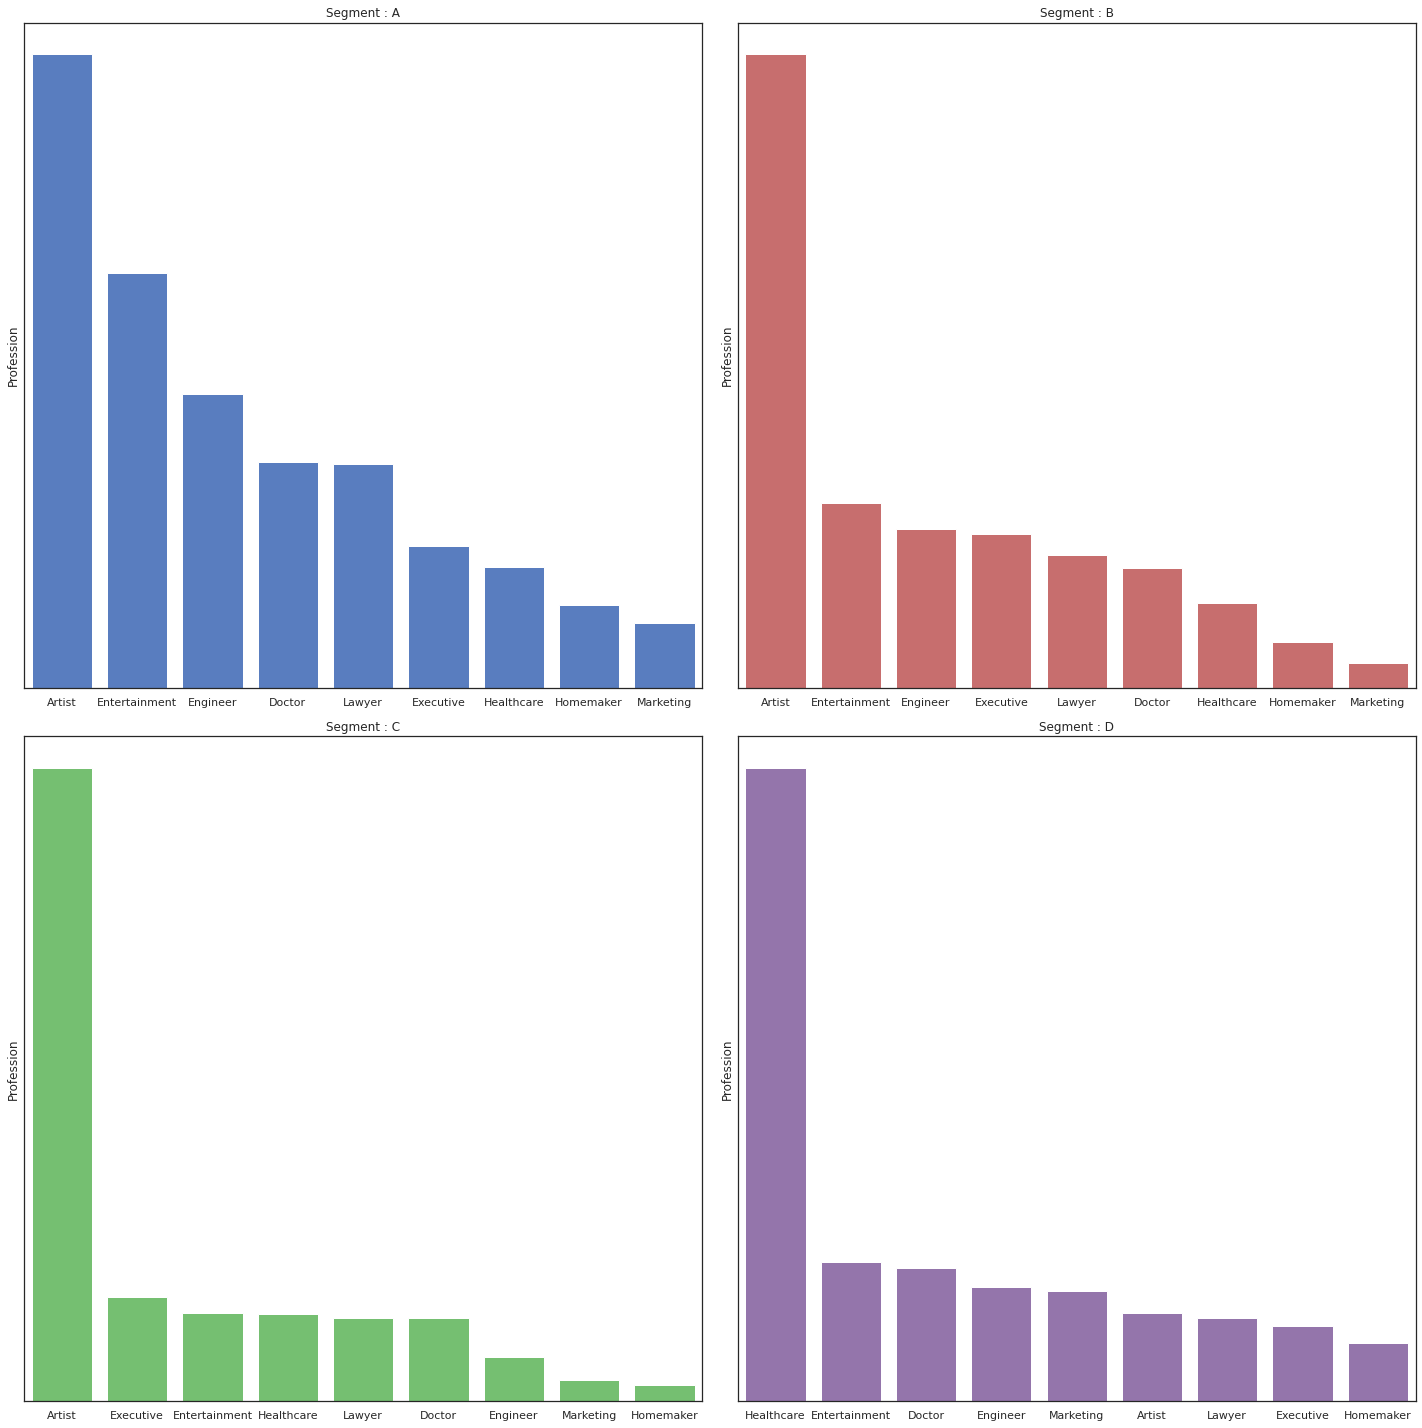

In [14]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(20, 20))
#sns.despine(left=True)

sns.barplot(train_data[train_data.Segmentation =='A']["Profession"].value_counts().index,train_data[train_data.Segmentation =='A']["Profession"].value_counts(),  color="b", ax=axes[0, 0]).set_title('Segment : A')

sns.barplot(train_data[train_data.Segmentation =='B']["Profession"].value_counts().index,train_data[train_data.Segmentation =='B']["Profession"].value_counts(),   color="r", ax=axes[0, 1]).set_title('Segment : B')

sns.barplot(train_data[train_data.Segmentation =='C']["Profession"].value_counts().index,train_data[train_data.Segmentation =='C']["Profession"].value_counts(),  color="g", ax=axes[1, 0]).set_title('Segment : C')

sns.barplot(train_data[train_data.Segmentation =='D']["Profession"].value_counts().index,train_data[train_data.Segmentation =='D']["Profession"].value_counts(), color="m", ax=axes[1, 1]).set_title('Segment : D')

plt.setp(axes, yticks=[])
plt.tight_layout()

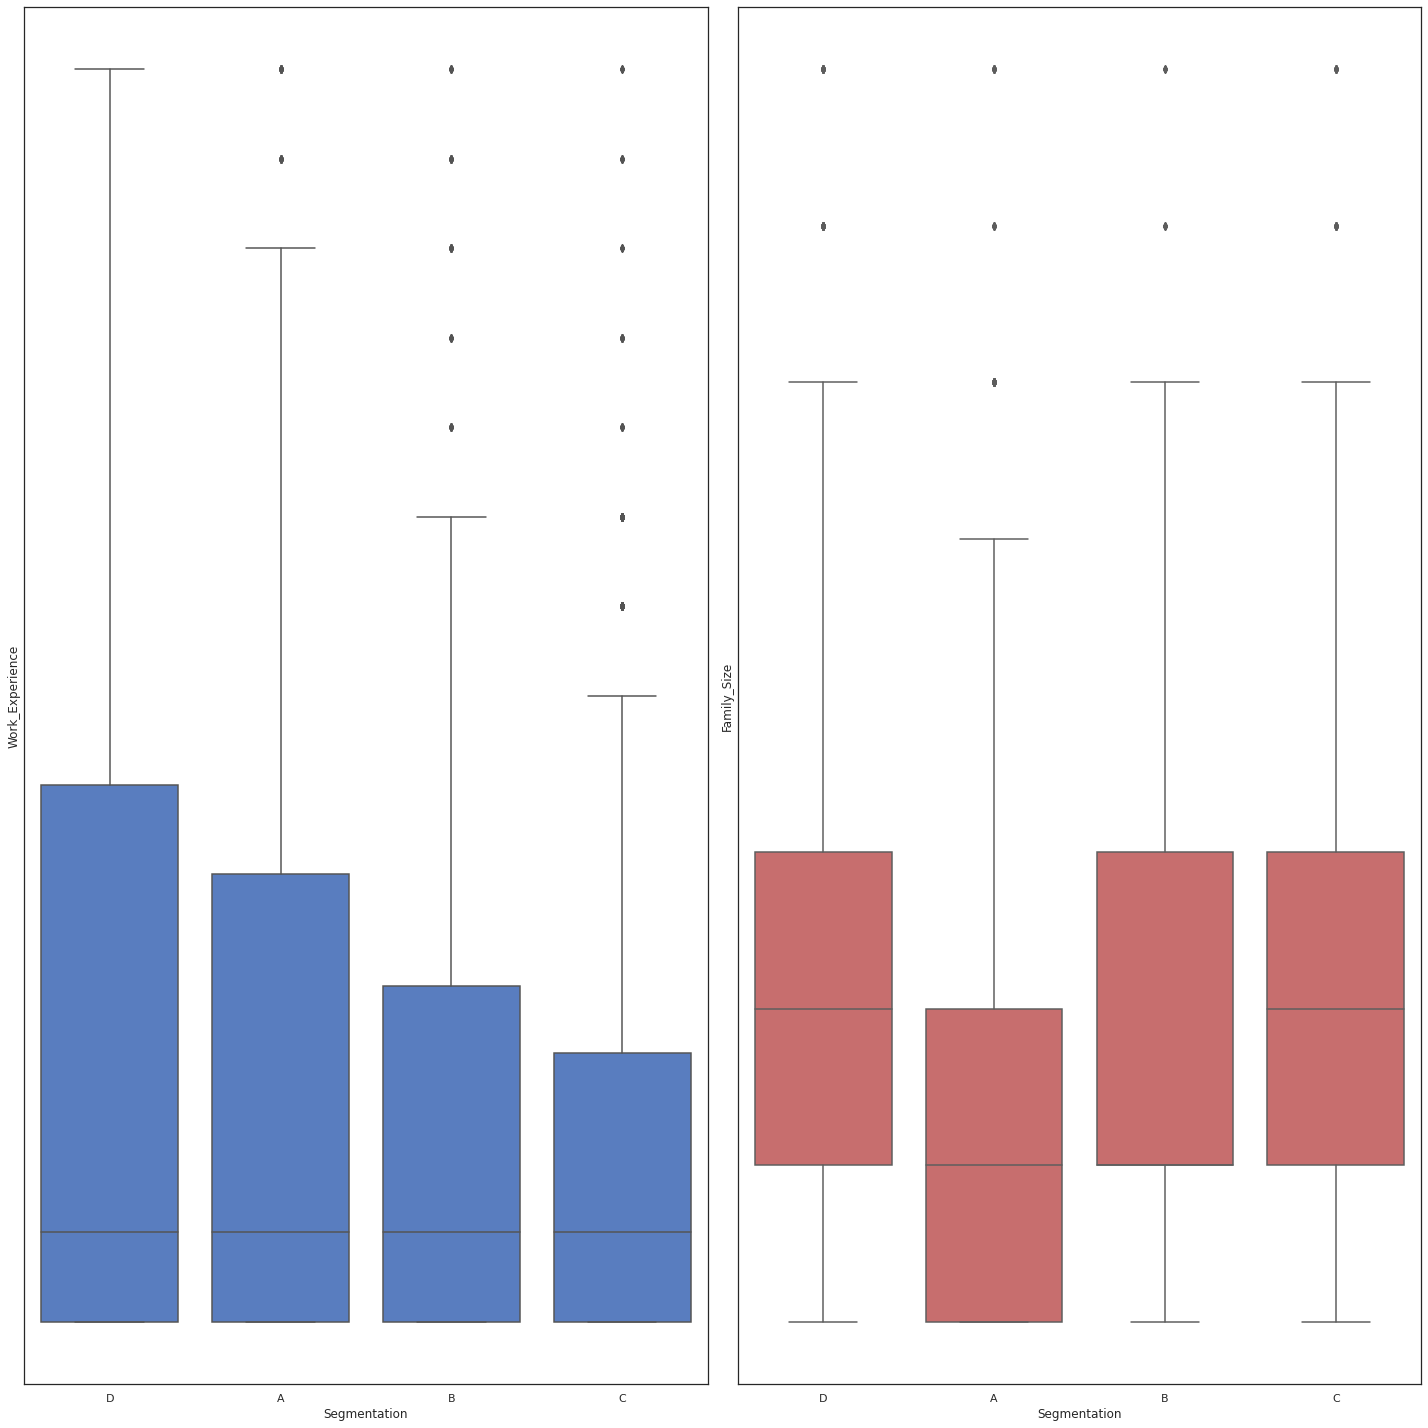

In [15]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(20, 20))
#sns.despine(left=True)

sns.boxplot(train_data['Segmentation'],train_data['Work_Experience'],  color="b", ax=axes[0])

sns.boxplot(train_data['Segmentation'],train_data['Family_Size'],  color="r", ax=axes[1])


plt.setp(axes, yticks=[])
plt.tight_layout()

In [16]:
train_data["Age"].value_counts()

35    250
37    234
33    232
42    232
27    229
     ... 
78     29
87     28
76     27
80     24
85     22
Name: Age, Length: 67, dtype: int64

In [17]:
train_data['Var_1'].value_counts()

Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: Var_1, dtype: int64

In [18]:
train_data['Profession'].value_counts()

Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64

In [19]:
train_data['Family_Size'].value_counts()

2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: Family_Size, dtype: int64

In [20]:
train_data['Graduated'].value_counts()

Yes    4968
No     3022
Name: Graduated, dtype: int64

In [21]:
train_data['Work_Experience'].value_counts()

1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: Work_Experience, dtype: int64

In [22]:
train_data['Spending_Score'].value_counts()

Low        4878
Average    1974
High       1216
Name: Spending_Score, dtype: int64

In [23]:
train_ids = train_data["ID"]
test_ids = test_data["ID"]
#set(train_ids).intersection(set(test_ids))

In [24]:
print(len(train_data['ID'].unique()))
print(len(test_data['ID'].unique()))
print("Duplicate Ids: ",len(set(train_ids).intersection(set(test_ids))))

8068
2627
Duplicate Ids:  2332


In [25]:
def create_submission_file(model_list,test):
    df = test.copy()
    preds = np.zeros(shape= (len(df),4))
    submission = pd.read_csv('../input/customersegmentation/CustomerSegmentation/sample_submission.csv')

    submission = pd.merge(submission,train_data , on = 'ID', how= 'left')[['ID','Segmentation_y']].rename(columns = {'ID':'ID','Segmentation_y':'Segmentation'})
    
    for model in model_list:
        preds = preds + (model.predict_proba(df.iloc[:,1:]))
    
    df["Segmentation"] = np.argmax(preds,axis =1)
    df["Segmentation"] = df["Segmentation"].map({0:'A',1:'B',2:'C',3:'D'})
    
    preds_dict = df[['ID','Segmentation']].set_index('ID').to_dict()
    
    for key, val in preds_dict['Segmentation'].items():
        submission.loc[(submission.ID == key),'Segmentation'] = val
    
    print(submission)
    
    submission.to_csv('submission.csv', index = False, header = True)

In [26]:
sub = pd.read_csv('../input/customersegmentation/CustomerSegmentation/sample_submission.csv')['ID']
sub = pd.merge(sub,train_data , on = 'ID', how= 'left')
temp_train_data1 = sub[sub.Segmentation.isna() == 0]
temp_train_data1.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,42.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,38.0,Yes,Healthcare,8.0,Average,4.0,Cat_6,C
2,458996,Female,Yes,71.0,No,NaN,1.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,58.0,No,Executive,12.0,High,2.0,Cat_6,C
4,459001,Female,No,20.0,No,Marketing,NaN,Low,4.0,Cat_6,C


In [27]:
temp_test_data = test_data[test_data.ID.isin(sub[sub.Segmentation.isna() == 1]['ID'])]

In [28]:
#temp_train_data.to_csv('temp.csv')

In [29]:
#temp_train_data = train_data[(train_data.Age  != 89)]

In [30]:
combined_data = pd.concat([train_data,temp_test_data],axis = 0)

In [31]:
#'Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size', 'Var_1'
combined_data['Ever_Married'] = combined_data['Ever_Married'].fillna('unk')
combined_data['Graduated'] = combined_data['Graduated'].fillna('unk')
combined_data['Profession'] = combined_data['Profession'].fillna('unk')
combined_data['Work_Experience'] = combined_data["Work_Experience"].fillna(-1)
combined_data['Family_Size'] = combined_data["Family_Size"].fillna(-1)
combined_data['Var_1'] = combined_data['Var_1'].fillna('unk')

In [32]:
#combined_data['Age_Category'] = 'all'
#combined_data.loc[(combined_data.Age <= 25) & (combined_data.Age >= 18),['Age_Category']] = '18_25'
#combined_data.loc[(combined_data.Age <= 35) & (combined_data.Age >= 26),['Age_Category']] = '26_35'
#combined_data.loc[(combined_data.Age <= 45) & (combined_data.Age >= 36),['Age_Category']] = '36_45'
#combined_data.loc[(combined_data.Age <= 55) & (combined_data.Age >= 46),['Age_Category']] = '46_55'
#combined_data.loc[combined_data.Age >= 56,['Age_Category']]= '>55'
#combined_data = combined_data.drop(columns = ['Age'])

In [33]:
combined_data = combined_data.sort_values(['ID'])
combined_data = combined_data.reset_index(drop =  True)
combined_data_cat = combined_data.copy()

In [34]:
le = LabelEncoder()
#combined_data['f1'] = le.fit_transform(combined_data['Age'].astype(str) +"_" + combined_data['Profession'])

In [35]:
combined_data['Gender'] = combined_data['Gender'].map({'Male':1,'Female':2})
combined_data['Ever_Married'] = combined_data['Ever_Married'].map({'No':1,'Yes':2,'unk':3})
combined_data['Graduated'] = combined_data['Graduated'].map({'No':1,'Yes':2,'unk':3})
combined_data['Profession'] = combined_data['Profession'].map({'Artist':1,'Healthcare':2,'Entertainment':3,'Engineer':4,'Doctor':5,'Lawyer':6,'Executive':7,'Marketing':8,'Homemaker':9,'unk':10})
combined_data['Spending_Score'] = combined_data['Spending_Score'].map({'Low':1,'Average':2,'High':3})
combined_data["Var_1"] = combined_data['Var_1'].map({'Cat_1':1,'Cat_2':2,'Cat_3':3,'Cat_4':4,'Cat_5':5,'Cat_6':6,'Cat_7':7,'unk':8})
combined_data['Segmentation'] = combined_data['Segmentation'].map({'A':0,'B':1,'C':2,'D':3})

In [36]:
#combined_data["Group"] = 0
#combined_data.loc[0,"Group"] = 1
#combined_data["Group_First"] = 0
#combined_data.loc[0,"Group_First"] = 1
#combined_data['Group_Last'] = 0
#combined_data["Group_Oldest"] = 0
#combined_data['Group_Youngest'] = 0

In [37]:
#for idx, row in combined_data.iterrows():
#    if idx !=0:
#        if combined_data.loc[idx-1 , 'Profession'] == combined_data.loc[idx , 'Profession']:
#            combined_data.loc[idx , 'Group'] = combined_data.loc[idx-1 , 'Group']
#            combined_data.loc[idx ,"Group_First"] = 0
#        else:
#            combined_data.loc[idx , 'Group'] = combined_data.loc[idx-1 , 'Group'] + 1
#            combined_data.loc[idx ,"Group_First"] = 1
#            combined_data.loc[idx-1 ,"Group_Last"] = 1
    
    

In [38]:
#combined_data["Group_Oldest"] = combined_data.groupby('Group')['Age'].transform('max')
#combined_data['Group_Youngest'] = combined_data.groupby('Group')['Age'].transform('min')
#combined_data['Group_Age_Mean'] = combined_data.groupby('Group')['Age'].transform('mean')
#combined_data['Group_Age_STD'] = combined_data.groupby('Group')['Age'].transform('std').fillna(-1)
#combined_data.head(50)

In [39]:
combined_data['magic1'] = combined_data['ID']%7
combined_data['magic2'] = combined_data['ID']%30
combined_data['magic3'] = combined_data['ID']%365
combined_data['magic4'] = combined_data['ID']//7
combined_data['magic5'] = combined_data['ID']//365
combined_data['magic6'] = combined_data['ID']//90
combined_data['magic7'] = combined_data['ID']%90
combined_data['magic8'] = (combined_data['ID'].values - 458982)
combined_data['magic9'] = (combined_data['ID'].values - 458982)//7
combined_data['magic10'] = (combined_data['ID'].values - 458982)//30
combined_data['magic11'] = np.sin((combined_data['ID']-combined_data['ID'].mean())*2*3.14/combined_data['ID'].std())
combined_data['magic12'] = np.cos((combined_data['ID']-combined_data['ID'].mean())*2*3.14/combined_data['ID'].std())
#combined_data['magic13'] = 
#combined_data['magic14'] = combined_data.groupby(['Profession','Spending_Score'])['ID'].transform('std')
#combined_data['magic14'] = combined_data.groupby('Family_Size')['ID'].apply(lambda x : (x - np.sin((x - x.mean())/x.std())))

In [40]:
#combined_data['magic1'] = combined_data['Age']%7
#combined_data['magic2'] = combined_data['Age']%30
#combined_data['magic3'] = combined_data['Age']%365

In [41]:
#combined_data['magic13'] = combined_data['ID']//combined_data['Age']
#combined_data['magic14'] = combined_data['ID']%combined_data['Age']
#combined_data['magic6'] = combined_data['Age']//90
#combined_data['magic7'] = combined_data['Age']%90

In [42]:
#combined_data['Work_Ex_Per_Spending_Score'] = combined_data['Work_Experience']/combined_data['Spending_Score']
#combined_data['Age_Per_Spending_Score'] = combined_data['Age']/combined_data['Spending_Score']
#combined_data['Family_Size_per_Score'] = combined_data['Family_Size']/combined_data['Spending_Score']
#combined_data['Avg_Family_Size_Spending'] = combined_data.groupby('Family_Size')['Spending_Score'].transform('mean')
#combined_data['diff'] = combined_data['Age'] - combined_data['Work_Experience']

In [43]:
#combined_data['Age_Category'] = 0
#combined_data.loc[(combined_data.Age <= 25) & (combined_data.Age >= 18),['Age_Category']] = 1
#combined_data.loc[(combined_data.Age <= 35) & (combined_data.Age >= 26),['Age_Category']] = 2
#combined_data.loc[(combined_data.Age <= 45) & (combined_data.Age >= 36),['Age_Category']] = 3
#combined_data.loc[(combined_data.Age <= 55) & (combined_data.Age >= 46),['Age_Category']] = 4
#combined_data.loc[combined_data.Age >= 56,['Age_Category']]= 5
#combined_data = combined_data.drop(columns = ['Age'])

In [44]:
#combined_data['Family_Type'] = 0
#combined_data.loc[(combined_data.Family_Size <= 2) ,['Family_Type']] = 1
#combined_data.loc[(combined_data.Family_Size <= 5) & (combined_data.Family_Size >= 3),['Family_Type']] = 2
#combined_data.loc[(combined_data.Family_Size >= 6),['Family_Type']] = 3
#combined_data = combined_data.drop(columns = ['Family_Size'])

In [45]:
#combined_data['Work_Ex_Type'] = 0
#combined_data.loc[(combined_data.Work_Experience == 1)  ,['Work_Ex_Type']] = 1
#combined_data.loc[(combined_data.Work_Experience >= 2) & (combined_data.Work_Experience <= 5),['Work_Ex_Type']] = 2
#combined_data.loc[(combined_data.Work_Experience >= 6) & (combined_data.Work_Experience <= 10),['Work_Ex_Type']]  = 3
#combined_data.loc[(combined_data.Work_Experience >= 11) & (combined_data.Work_Experience <= 15),['Work_Ex_Type']] =4
#combined_data = combined_data.drop(columns = ['Work_Experience'])

In [46]:
#combined_data['Age_lag'] = combined_data['Age'].rolling(window = 5).mean().fillna(-1)
#combined_data['Age_lag1'] = combined_data.sort_values(['ID']).groupby(['Age'])['ID'].apply(lambda x : x.rolling(window = 5,min_periods =1).mean()).fillna(-1)
#combined_data['Age_lag1'] = combined_data.sort_values(['ID']).groupby(['Work_Experience'])['ID'].apply(lambda x : x.rolling(window = 5,min_periods =1).mean()).fillna(-1)
#combined_data['Age_lag2'] = combined_data.sort_values(['ID']).groupby(['Age'])['Segmentation'].apply(lambda x : x.shift(2)).fillna(-1)
#combined_data['Age_lag3'] = combined_data.sort_values(['ID']).groupby(['Age'])['Segmentation'].apply(lambda x : x.shift(3)).fillna(-1)
#combined_data['Age_lag4'] = combined_data.sort_values(['ID']).groupby(['Age'])['Segmentation'].apply(lambda x : x.shift(4)).fillna(-1)
#combined_data['Age_lag5'] = combined_data.sort_values(['ID']).groupby(['Age'])['Segmentation'].apply(lambda x : x.shift(5)).fillna(-1)
#combined_data['work_roll5'] = combined_data.sort_values(['ID']).groupby(['Work_Experience'])['Segmentation'].apply(lambda x : x.rolling(window = 5,min_periods =1).mean()).fillna(-1)

In [47]:
combined_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,magic3,magic4,magic5,magic6,magic7,magic8,magic9,magic10,magic11,magic12
0,458982,1,2,61,2,7,1.0,3,3.0,6,...,177,65568,1257,5099,72,0,0,0,0.991068,-0.133355
1,458983,2,2,63,2,7,0.0,3,5.0,6,...,178,65569,1257,5099,73,1,0,0,0.990743,-0.135751
2,458984,1,2,39,2,1,0.0,2,3.0,6,...,179,65569,1257,5099,74,2,0,0,0.990412,-0.138146
3,458985,1,1,23,1,2,1.0,1,4.0,6,...,180,65569,1257,5099,75,3,0,0,0.990075,-0.140540
4,458986,1,1,18,1,2,7.0,1,4.0,6,...,181,65569,1257,5099,76,4,0,0,0.989732,-0.142933


In [48]:
features = [col for col in combined_data.columns if col !='ID' and col != 'Segmentation' and col != 'Group'  ]

In [49]:
train_features = combined_data.loc[(combined_data.Segmentation.isna() == 0 ),features]
target = combined_data.loc[(combined_data.Segmentation.isna() == 0 ),'Segmentation'].astype(int)

X_test = combined_data.loc[(combined_data.ID.isin(set(test_ids) - set(train_ids))),['ID'] + features]

In [50]:
train_features.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'magic1',
       'magic2', 'magic3', 'magic4', 'magic5', 'magic6', 'magic7', 'magic8',
       'magic9', 'magic10', 'magic11', 'magic12'],
      dtype='object')

In [51]:
train_features.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,magic1,...,magic3,magic4,magic5,magic6,magic7,magic8,magic9,magic10,magic11,magic12
0,1,2,61,2,7,1.0,3,3.0,6,6,...,177,65568,1257,5099,72,0,0,0,0.991068,-0.133355
1,2,2,63,2,7,0.0,3,5.0,6,0,...,178,65569,1257,5099,73,1,0,0,0.990743,-0.135751
2,1,2,39,2,1,0.0,2,3.0,6,1,...,179,65569,1257,5099,74,2,0,0,0.990412,-0.138146
3,1,1,23,1,2,1.0,1,4.0,6,2,...,180,65569,1257,5099,75,3,0,0,0.990075,-0.140540
4,1,1,18,1,2,7.0,1,4.0,6,3,...,181,65569,1257,5099,76,4,0,0,0.989732,-0.142933


In [52]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = []
X_train_cv,y_train_cv = train_features.copy(), target.copy()
for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
    print('Fold',i)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = lgb.LGBMClassifier(
            n_estimators=500,
            max_depth=12,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.4,
            objective = 'multiclass'
        )        
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                verbose=100,eval_metric='multi_logloss',
                early_stopping_rounds=50)
    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
    scores.append(acc)
    print ('LGB Val CV=',acc)
    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
    print('#'*100)


print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 6454 rows of holdout = 1614
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.04791
Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 1.04701
LGB Val CV= 0.5322180916976456
[[190  85  38  81]
 [ 88 133 102  49]
 [ 41  77 223  53]
 [ 97  30  14 313]]
####################################################################################################
Fold 1
 rows of train = 6454 rows of holdout = 1614
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.06422
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 1.06008
LGB Val CV= 0.5359355638166047
[[193  72  48  82]
 [102 131  94  44]
 [ 29  81 231  53]
 [107  25  12 310]]
####################################################################################################
Fold 2
 rows of train = 6454 rows of holdout = 1614
Training until validation scores don't improve for 50 rounds
[100]	valid_0's mu

In [53]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = []
X_train_cv,y_train_cv = train_features.copy(), target.copy()
for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
    print('Fold',i)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.4,
            objective = 'multi:softprob'
        )        
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                verbose=100,eval_metric='merror',
                early_stopping_rounds=50)
    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
    scores.append(acc)
    print ('XGB Val CV=',acc)
    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
    print('#'*100)


print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 6454 rows of holdout = 1614
[0]	validation_0-merror:0.55080
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.47522
Stopping. Best iteration:
[105]	validation_0-merror:0.46468

XGB Val CV= 0.5353159851301115
[[187  84  43  80]
 [ 83 133 104  52]
 [ 41  72 228  53]
 [104  25   9 316]]
####################################################################################################
Fold 1
 rows of train = 6454 rows of holdout = 1614
[0]	validation_0-merror:0.53532
Will train until validation_0-merror hasn't improved in 50 rounds.
[100]	validation_0-merror:0.47955
Stopping. Best iteration:
[51]	validation_0-merror:0.46902

XGB Val CV= 0.5309789343246593
[[189  64  48  94]
 [103 124  94  50]
 [ 42  66 231  55]
 [101  26  14 313]]
####################################################################################################
Fold 2
 rows of train = 6454 rows of holdout = 1614
[0]	validation_0-merror:0.51425
Will tr

In [54]:
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#scores = []
#X_train_cv,y_train_cv = train_features.copy(), target.copy()
#for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
#    print('Fold',i)
#    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
#    clf = CatBoostClassifier(
#    iterations=500,
#    learning_rate=0.1,
#    random_strength=0.1,
#    depth=8,
#    loss_function='MultiClass',
#    eval_metric='Accuracy',
#    leaf_estimation_method='Newton'
#)    
    
#    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
#                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
#               early_stopping_rounds=50,verbose = 0)
#    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
#    scores.append(acc)
#    print ('CatBoost Val CV=',acc)
#    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
#    print('#'*100)


#print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

In [55]:
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#scores = []
#X_train_cv,y_train_cv = train_features.copy(), target.copy()
#for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
#    print('Fold',i)
#    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
#    clf = RandomForestClassifier(n_estimators=500 ,
#                             max_depth=6, min_samples_split=2, 
#                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#                             n_jobs=-1, random_state=123, verbose=0) 
#    
##    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT])
##    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
#    scores.append(acc)
 #   print ('RFC Val CV=',acc)
#    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
#    print('#'*100)


#print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

In [56]:
def feature_importance(model, X_train):

    print(model.feature_importances_)
    names = X_train.columns.values
    ticks = [i for i in range(len(names))]
    plt.bar(ticks, model.feature_importances_)
    plt.xticks(ticks, names,rotation =90)
    plt.show()

In [57]:
#X_train, X_val, y_train, y_val = train_test_split(train_features,target , test_size=0.2, random_state=1)
trees = 15
seeds = [32,432,45,76,93,67]

In [58]:
#model_cat = [0] *trees*len(seeds)
#for i in range(trees*len(seeds)):

#        print("Tree {0:d}".format(i+1))
#        j = 0
#        X_train, X_val, y_train, y_val = train_test_split(train_features,target , test_size=0.2)
#        if i%30 == 0:
#            random_state = seeds[j]
#            j +=1
            
#        model_cat[i] = CatBoostClassifier(
#                            iterations=500,
#                            learning_rate=0.1,
#                            random_strength=0.1,
#                            depth=6,
###                            loss_function='MultiClass',
##                            eval_metric='Accuracy',
#                            leaf_estimation_method='Newton',
#                            random_seed = random_state
#                        )    
#    
#        model_cat[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
###                        eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
##                       early_stopping_rounds=50,verbose = 0)
#        
#        
#        print("Multi Log Loss {0:.5f}".format(model_cat[i].get_best_score()['validation']['MultiClass']))

In [59]:
model_lgb = [0] *trees*len(seeds)
avg_loss = []
for i in range(trees*len(seeds)):

        print("Tree {0:d}".format(i+1))
        j = 0
        X_train, X_val, y_train, y_val = train_test_split(train_features,target , test_size=0.2)
        if i%30 == 0:
            random_state = seeds[j]
            j +=1
        model_lgb[i] = lgb.LGBMClassifier(boosting_type='gbdt',
                               n_estimators= 500,
                               max_depth=8,
                               learning_rate=0.1,
                               subsample=0.8,
                               colsample_bytree=0.4,
                               objective = 'multiclass',
                               random_state = random_state
                              )
        
        model_lgb[i].fit(X_train, y_train,
              eval_set=[(X_train, y_train),(X_val, y_val)],
              eval_metric=['multi_logloss'],
              early_stopping_rounds = 100,
              verbose=0)
        avg_loss.append(model_lgb[i].best_score_['valid_1']['multi_logloss'])
        print("Multi Log Loss {0:.5f}".format(model_lgb[i].best_score_['valid_1']['multi_logloss']))
        
print('#'*100)
print("Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

Tree 1
Multi Log Loss 1.04153
Tree 2
Multi Log Loss 1.01790
Tree 3
Multi Log Loss 1.02987
Tree 4
Multi Log Loss 1.01704
Tree 5
Multi Log Loss 1.03272
Tree 6
Multi Log Loss 1.03450
Tree 7
Multi Log Loss 1.03987
Tree 8
Multi Log Loss 1.02488
Tree 9
Multi Log Loss 1.02312
Tree 10
Multi Log Loss 1.01167
Tree 11
Multi Log Loss 1.04115
Tree 12
Multi Log Loss 1.03596
Tree 13
Multi Log Loss 1.02889
Tree 14
Multi Log Loss 1.01923
Tree 15
Multi Log Loss 1.04500
Tree 16
Multi Log Loss 1.00498
Tree 17
Multi Log Loss 1.02496
Tree 18
Multi Log Loss 1.04739
Tree 19
Multi Log Loss 1.03488
Tree 20
Multi Log Loss 1.02542
Tree 21
Multi Log Loss 1.02263
Tree 22
Multi Log Loss 1.04231
Tree 23
Multi Log Loss 1.02849
Tree 24
Multi Log Loss 1.05419
Tree 25
Multi Log Loss 1.02875
Tree 26
Multi Log Loss 0.99379
Tree 27
Multi Log Loss 1.04745
Tree 28
Multi Log Loss 0.99403
Tree 29
Multi Log Loss 1.04135
Tree 30
Multi Log Loss 1.05408
Tree 31
Multi Log Loss 1.04547
Tree 32
Multi Log Loss 1.04624
Tree 33
Multi Log

[ 192  154 1080  189  538  510  294  467  314  313  557  909  887  114
  413  848  565  464  377 1024  979]


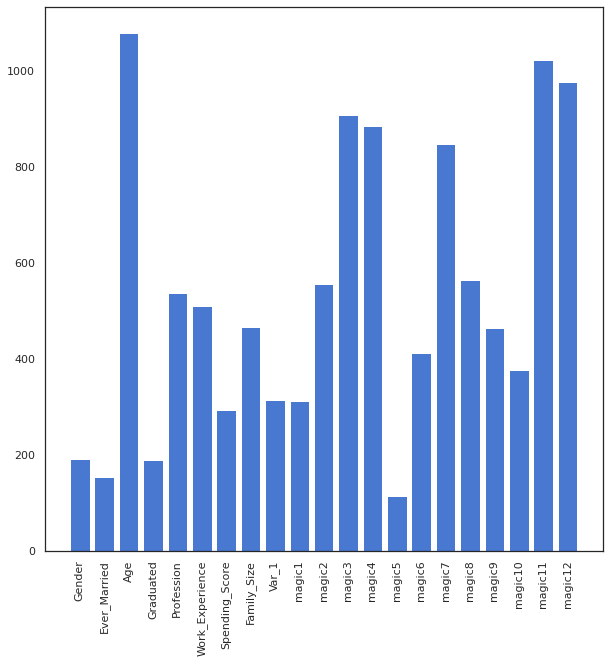

In [60]:
#print(model_lgb.best_score_['valid_1'])
feature_importance(model_lgb[0],train_features)

In [61]:
avg_loss = []
model_xgb = [0] *trees *len(seeds)
for i in range(trees *len(seeds)):
        print("Tree {0:d}".format(i+1))
        X_train, X_val, y_train, y_val = train_test_split(train_features,target , test_size=0.2)
        j = 0
        if i%30 == 0:
            random_state = seeds[j]
            j +=1
            
        model_xgb[i] = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.4,
            objective = 'multi:softprob',
            random_state = random_state
        )    
        
        model_xgb[i].fit(X_train, y_train,
              eval_set=[(X_train, y_train),(X_val, y_val)],
              eval_metric=['merror'],
              early_stopping_rounds = 50,
              verbose=0)
        #print(model_xgb[j].best_score)
        avg_loss.append(model_xgb[i].best_score)
        print("Multi Log Loss {0:.5f}".format(model_xgb[i].best_score))
        
print('#'*100)
print("Multi Log Loss Stats {0:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

Tree 1
Multi Log Loss 0.45477
Tree 2
Multi Log Loss 0.44672
Tree 3
Multi Log Loss 0.45105
Tree 4
Multi Log Loss 0.46035
Tree 5
Multi Log Loss 0.47026
Tree 6
Multi Log Loss 0.44052
Tree 7
Multi Log Loss 0.44176
Tree 8
Multi Log Loss 0.41450
Tree 9
Multi Log Loss 0.43866
Tree 10
Multi Log Loss 0.43990
Tree 11
Multi Log Loss 0.44238
Tree 12
Multi Log Loss 0.42813
Tree 13
Multi Log Loss 0.47708
Tree 14
Multi Log Loss 0.43185
Tree 15
Multi Log Loss 0.45787
Tree 16
Multi Log Loss 0.45911
Tree 17
Multi Log Loss 0.42813
Tree 18
Multi Log Loss 0.44610
Tree 19
Multi Log Loss 0.44795
Tree 20
Multi Log Loss 0.45167
Tree 21
Multi Log Loss 0.45291
Tree 22
Multi Log Loss 0.44610
Tree 23
Multi Log Loss 0.45477
Tree 24
Multi Log Loss 0.44300
Tree 25
Multi Log Loss 0.44981
Tree 26
Multi Log Loss 0.45787
Tree 27
Multi Log Loss 0.42999
Tree 28
Multi Log Loss 0.45291
Tree 29
Multi Log Loss 0.45415
Tree 30
Multi Log Loss 0.44610
Tree 31
Multi Log Loss 0.44734
Tree 32
Multi Log Loss 0.43742
Tree 33
Multi Log

In [62]:
create_submission_file(model_lgb,X_test)

          ID Segmentation
0     458989            B
1     458994            C
2     458996            A
3     459000            C
4     459001            C
...      ...          ...
2622  467954            D
2623  467958            A
2624  467960            A
2625  467961            B
2626  467968            D

[2627 rows x 2 columns]


In [63]:
#model_rfc = [0] *len(seeds)
#for i,seed in enumerate(seeds):
#        print("Tree {0:d}".format(i+1))
        
#        model_rfc[i] = RandomForestClassifier(n_estimators=500 ,
#                             max_depth=6, min_samples_split=2, 
#                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#                             n_jobs=-1, random_state=seed, verbose=0) 
       
        
#        model_rfc[i].fit(train_features.copy(), target.copy())
#        #print(model_xgb[j].best_score)


In [64]:
#create_submission_file(model_lgb+model_xgb+model_rfc,X_test)

# Logistic Regression CV
CV accuracy--->poor

In [65]:
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#scores = []
#X_train_cv,y_train_cv = train_features.copy(), target.copy()
#for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
#    print('Fold',i)
#    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
#    clf = LogisticRegression(max_iter = 500)
    
#    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT])
#    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
#    scores.append(acc)
#    print ('LogisticRegression Val CV=',acc)
#    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
#    print('#'*100)


#print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

# SVC CV
CV accuracy--->poor

In [66]:
#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#scores = []
#X_train_cv,y_train_cv = train_features.copy(), target.copy()
#for i, (idxT, idxV) in enumerate(rskf.split(X_train_cv, y_train_cv)):
#    print('Fold',i)
#    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
#    clf = SVC(max_iter = -1,probability=True)
#    
#    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT])
#    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))
#    scores.append(acc)
#    print ('SVC Val CV=',acc)
#    print(confusion_matrix(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1)))
#    print('#'*100)


#print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))